# SWD Properties

## Setup

::: {#cell-2 .cell 0=‘h’ 1=‘i’ 2=‘d’ 3=‘e’ execution_count=36}

``` python
import polars as pl
from loguru import logger
```

:::

::: {#cell-3 .cell 0=‘h’ 1=‘i’ 2=‘d’ 3=‘e’ execution_count=37}

``` python
%load_ext autoreload
%autoreload 2
```

    The autoreload extension is already loaded. To reload it, use:
      %reload_ext autoreload

:::

Connect `python` with `R` kernel

In [65]:
from beforerr.r import py2rpy_polars
import rpy2.robjects as robjects

%load_ext rpy2.ipython

r = robjects.r
r.source('utils.R')

conv_pl = py2rpy_polars()

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython

## Processing datasets

In [39]:
ts = 1 # unit: seconds
tau = 60 # unit: seconds
data_dir = "../data"
format = "arrow"

In [40]:
from utils import load_events, PARAMETERS

wind_df = load_events('Wind', 1, 60, 'fit')
sta_df = load_events('STA', 1, 60, 'fit')
jno_df = load_events('JNO', 1, 60, 'fit')
jno_df_tau_300 = load_events('JNO', 1, 300, 'fit')
jno_df_8hz = load_events('JNO', 0.125, 60, 'fit')
jno_df_8hz_tau_20 = load_events('JNO', 0.125, 20, 'fit')
jno_df_8hz_tau_20_der = load_events('JNO', 0.125, 20, 'derivative')

other_events = pl.concat([wind_df, sta_df], how='diagonal')

logger.info(f"Columns: {jno_df.columns}")

2024-02-18 21:55:57.510 | INFO     | __main__:<module>:13 - Columns: ['time', 'tstart', 'tstop', 'd_tstart', 'd_tstop', 'd_time', 'time_before', 'time_after', 'count', 'B_std', 'B_mean', 'dB_vec', 'index_diff', 'index_std', 'index_fluctuation', 'B.after', 'B.before', 'b_mag', 'b_n', 'bn_over_b', 'd_star', 'db_mag', 'db_over_b', 'db_over_b_max', 'fit.stat.chisqr', 'fit.stat.rsquared', 'fit.vars.amplitude', 'fit.vars.c', 'fit.vars.sigma', 'rotation_angle', 'dB_x', 'dB_y', 'dB_z', 'dB_lmn_x', 'dB_lmn_y', 'dB_lmn_z', 'k_x', 'k_y', 'k_z', 'Vl_x', 'Vl_y', 'Vl_z', 'Vn_x', 'Vn_y', 'Vn_z', 'duration', 'radial_distance', 'plasma_density', 'plasma_temperature', 'model_b_r', 'model_b_t', 'model_b_n', 'v_x', 'v_y', 'v_z', 'plasma_speed', 'B_background_x', 'B_background_y', 'B_background_z', 'v_x_before', 'v_y_before', 'v_z_before', 'n.before', 'v.ion.before', 'plasma_temperature_before', 'v_x_after', 'v_y_after', 'v_z_after', 'n.after', 'v.ion.after', 'plasma_temperature_after', 'v_l', 'v_n', 'v_k'

Some extreme values are present in the data. We will remove them.

In [41]:
DISPLAY_VARS = ['time', 'sat'] + PARAMETERS

def check_candidates(df):
    if isinstance(df, pl.LazyFrame):
        df = df.collect()
    logger.info(df.columns)
    return df.select(DISPLAY_VARS).describe()

check_candidates(jno_df)

2024-02-18 21:55:57.523 | INFO     | __main__:check_candidates:6 - ['time', 'tstart', 'tstop', 'd_tstart', 'd_tstop', 'd_time', 'time_before', 'time_after', 'count', 'B_std', 'B_mean', 'dB_vec', 'index_diff', 'index_std', 'index_fluctuation', 'B.after', 'B.before', 'b_mag', 'b_n', 'bn_over_b', 'd_star', 'db_mag', 'db_over_b', 'db_over_b_max', 'fit.stat.chisqr', 'fit.stat.rsquared', 'fit.vars.amplitude', 'fit.vars.c', 'fit.vars.sigma', 'rotation_angle', 'dB_x', 'dB_y', 'dB_z', 'dB_lmn_x', 'dB_lmn_y', 'dB_lmn_z', 'k_x', 'k_y', 'k_z', 'Vl_x', 'Vl_y', 'Vl_z', 'Vn_x', 'Vn_y', 'Vn_z', 'duration', 'radial_distance', 'plasma_density', 'plasma_temperature', 'model_b_r', 'model_b_t', 'model_b_n', 'v_x', 'v_y', 'v_z', 'plasma_speed', 'B_background_x', 'B_background_y', 'B_background_z', 'v_x_before', 'v_y_before', 'v_z_before', 'n.before', 'v.ion.before', 'plasma_temperature_before', 'v_x_after', 'v_y_after', 'v_z_after', 'n.after', 'v.ion.after', 'plasma_temperature_after', 'v_l', 'v_n', 'v_k', 

In [42]:
def remove_extreme(df, cols = ['j0_k', 'L_k'], q = 0.96):
    filter_conditions = [
        pl.col(col) < pl.col(col).quantile(q) for col in cols
    ] + [
        pl.col(col) > pl.col(col).quantile(1-q) for col in cols
    ]
    
    return df.filter(filter_conditions)

def keep_good_fit(df: pl.DataFrame, rsquared = 0.95):
    return df.filter(pl.col('fit.stat.rsquared') > rsquared)

# jno_df = jno_df.pipe(remove_extreme).pipe(keep_good_fit)
# other_events = other_events.pipe(remove_extreme).pipe(keep_good_fit)
# jno_df_tau_300 = jno_df_tau_300.pipe(remove_extreme).pipe(keep_good_fit)

jno_df = jno_df.pipe(keep_good_fit)
other_events = other_events.pipe(keep_good_fit)
jno_df_tau_300 = jno_df_tau_300.pipe(keep_good_fit)
jno_df_8hz = jno_df_8hz.pipe(keep_good_fit)
jno_df_8hz_tau_20 = jno_df_8hz_tau_20.pipe(keep_good_fit)
jno_df_8hz_tau_20_der = jno_df_8hz_tau_20_der.filter(pl.col('len')==160, pl.col('index_d_diff')>0.8)

In [43]:
logger.info(f"Number of events > 5AU: {jno_df.filter(pl.col('radial_distance') > 4).height}")
logger.info(f"Number of events > 5AU: {jno_df.filter(pl.col('radial_distance') > 3, pl.col('radial_distance') < 4).height}")
logger.info(f"Number of events > 5AU: {jno_df_tau_300.filter(pl.col('radial_distance') > 4).height}")

2024-02-18 21:56:00.091 | INFO     | __main__:<module>:1 - Number of events > 5AU: 4207
2024-02-18 21:56:00.093 | INFO     | __main__:<module>:2 - Number of events > 5AU: 2033
2024-02-18 21:56:00.094 | INFO     | __main__:<module>:3 - Number of events > 5AU: 1035

## Plotting in R

In [44]:
%R -i jno_df -c conv_pl
%R -i other_events -c conv_pl
%R -i jno_df_tau_300 -c conv_pl
%R -i jno_df_8hz -c conv_pl
%R -i jno_df_8hz_tau_20 -c conv_pl
%R -i jno_df_8hz_tau_20_der -c conv_pl

In [45]:
%%R
p1title <- "a) Juno"
p2title <- "b) ARTEMIS, STEREO and Wind"
x_lab_r <- "Radial Distance (AU)"
x_lab_t <- "Time"

y_lab_t <- "Time Duration (s)"
y_lab_L <- "Log Thickness (km)"
y_lab_L_norm <- expression(Log~Thickness~(d[i]))

layout <- plot_layout(ncol = 2, byrow = FALSE, guides = "collect")

Saving 13.8 x 13.8 in image
Saving 13.8 x 13.8 in image

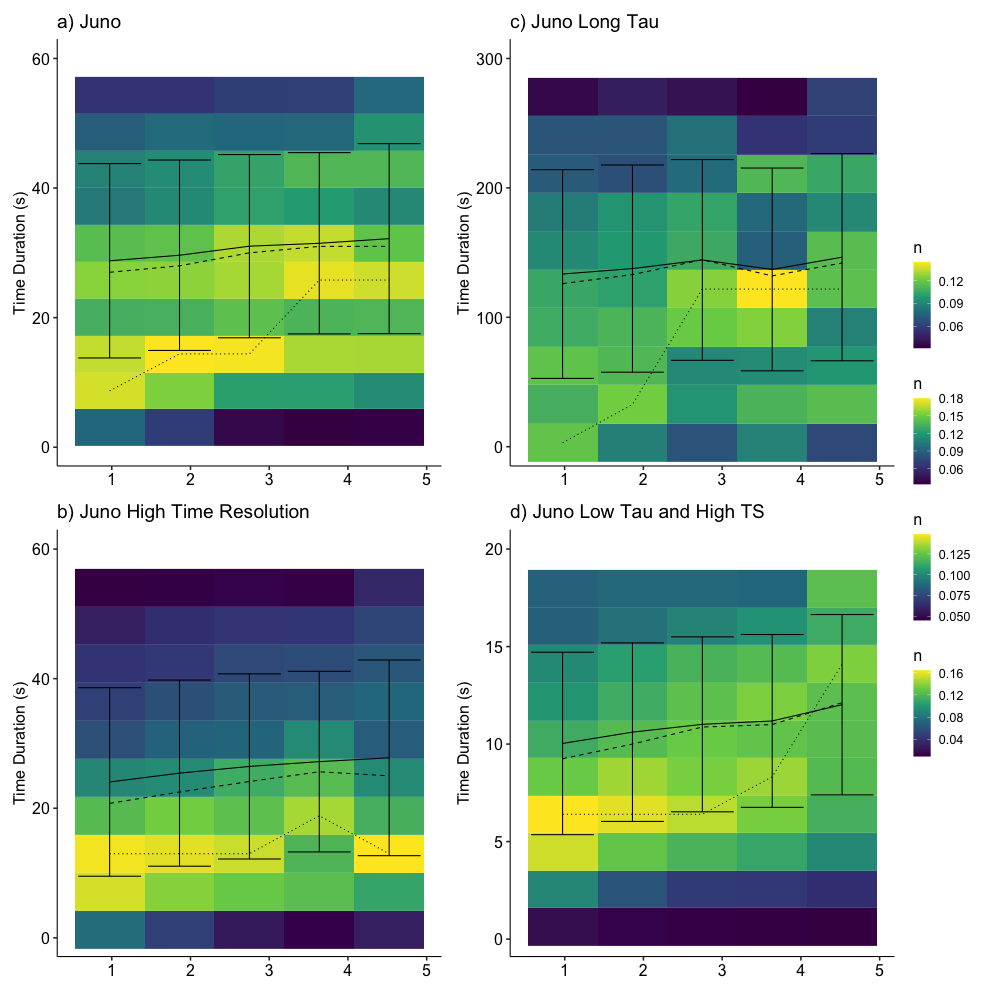

In [77]:
%%R -w 350 -h 350 -u mm
add_mode <- TRUE
x_bins <- 5
y_bins <- 10
log_y <- FALSE
y_lim_duration <- c(0.1, 60)

y_col <- "duration"
ylab <- y_lab_t

x_col <- "radial_distance"

p <- plot_binned_data(jno_df, x_col = x_col, y_col = y_col, x_bins = x_bins, y_bins = y_bins, y_lim = y_lim_duration, log_y = log_y, add_mode=add_mode)
p1 <- p + labs(x = NULL, y= ylab) + ggtitle("a) Juno")

p <- plot_binned_data(jno_df_8hz, x_col = x_col, y_col = y_col, x_bins = x_bins, y_bins = y_bins, y_lim = y_lim_duration, log_y = log_y, add_mode=add_mode)
p2 <- p + labs(x = NULL, y= ylab) + ggtitle("b) Juno High Time Resolution")

y_lim_duration <- c(0.1, 300)
p <- plot_binned_data(jno_df_tau_300, x_col = x_col, y_col = y_col, x_bins = x_bins, y_bins = y_bins, y_lim = y_lim_duration, log_y = log_y, add_mode=add_mode)
p3 <- p + labs(x = NULL, y= ylab) + ggtitle("c) Juno Long Tau")

y_lim_duration <- c(0.1, 20)
p <- plot_binned_data(jno_df_8hz_tau_20, x_col = x_col, y_col = y_col, x_bins = x_bins, y_bins = y_bins, y_lim = y_lim_duration, log_y = log_y, add_mode=add_mode)
p4 <- p + labs(x = NULL, y= ylab) + ggtitle("d) Juno Low Tau and High TS")

# p <- (p1 + p2) + plot_layout(ncol = 1, guides = "collect") & scale_fill_viridis_c(limits = c(0.01, 0.20), name="pdf")
p <- p1 + p2 + p3 + p4 + layout 
save_plot("new/duration/duration_dist_ts_comparison")
p

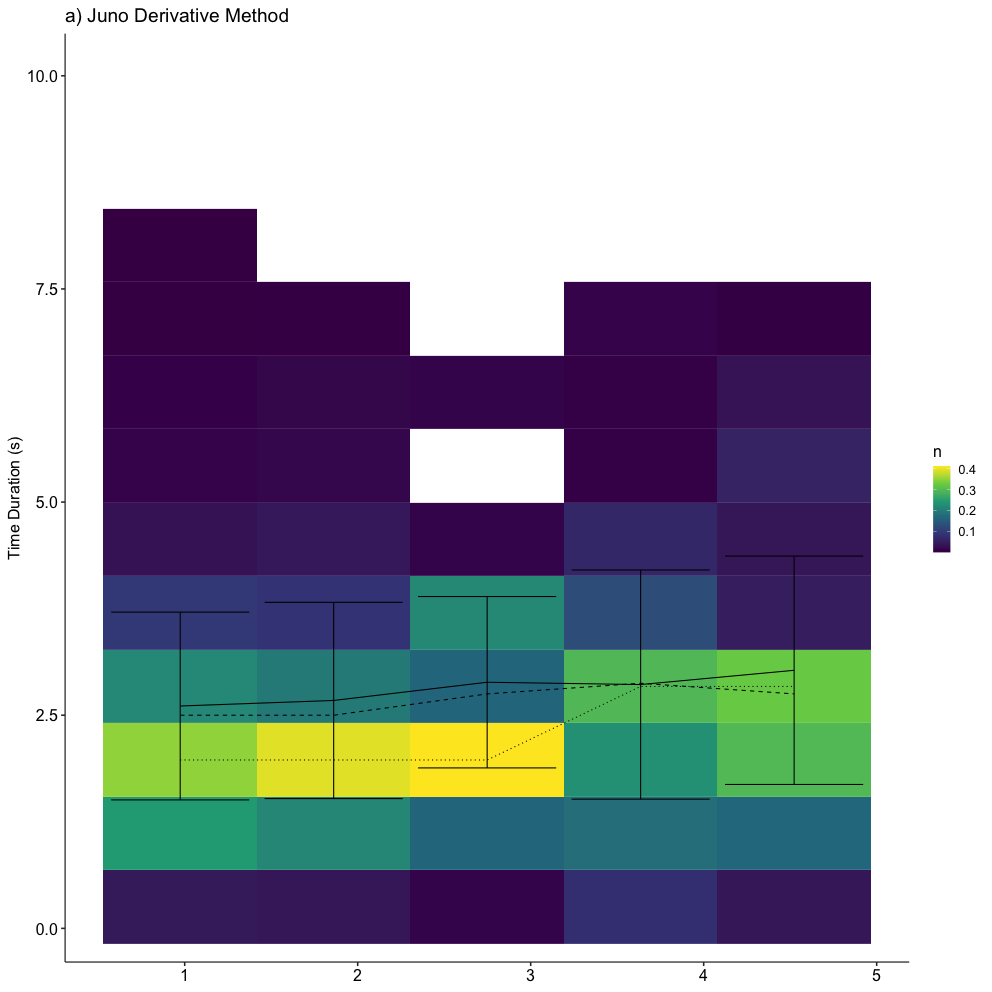

In [46]:
%%R -w 350 -h 350 -u mm
add_mode <- TRUE
x_bins <- 5
y_bins <- 10
log_y <- FALSE
y_lim_duration <- c(0.1, 10)

y_col <- "duration"
ylab <- y_lab_t

x_col <- "radial_distance"

p <- plot_binned_data(jno_df_8hz_tau_20_der, x_col = x_col, y_col = y_col, x_bins = x_bins, y_bins = y_bins, y_lim = y_lim_duration, log_y = log_y, add_mode=add_mode)
p1 <- p + labs(x = NULL, y= ylab) + ggtitle("a) Juno Derivative Method")
p1

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Saving 13.8 x 13.8 in image
Saving 13.8 x 13.8 in image

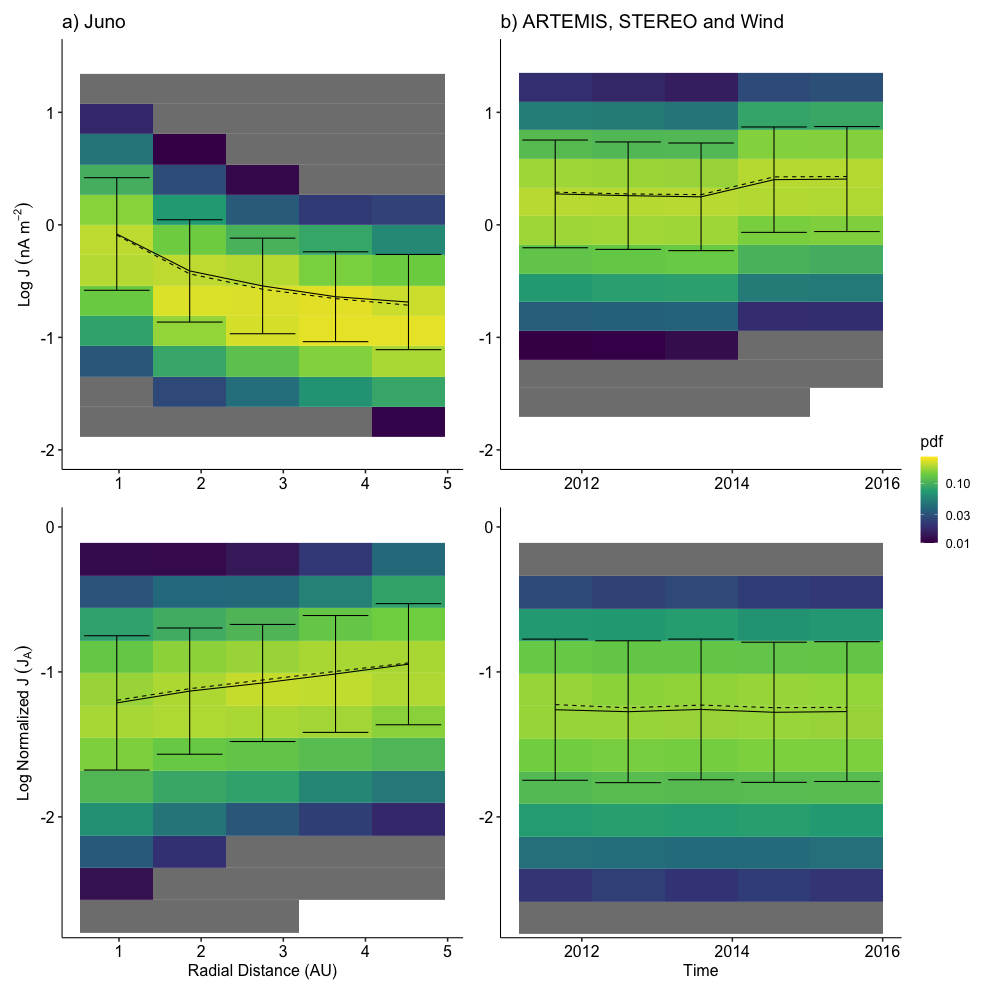

In [116]:
%%R -w 350 -h 350 -u mm

p <- plot_current_comparison(jno_df, other_events, p1title="a) Juno")
save_plot("new/current/current_k_dist")
p

In [118]:
%%R -w 350 -h 350 -u mm
p <- plot_current_comparison(jno_df_8hz_tau_20, other_events, p1title="a) Juno: High Time Resolution, Low Tau")
save_plot("new/current/current_k_dist-8hz-tau_20")

p <- plot_current_comparison(jno_df_8hz, other_events, p1title="a) Juno: High Time Resolution")
save_plot("new/current/current_k_dist-8hz")

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Saving 13.8 x 13.8 in image
Saving 13.8 x 13.8 in image
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Saving 13.8 x 13.8 in image
Saving 13.8 x 13.8 in image

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Saving 13.8 x 13.8 in image
Saving 13.8 x 13.8 in image

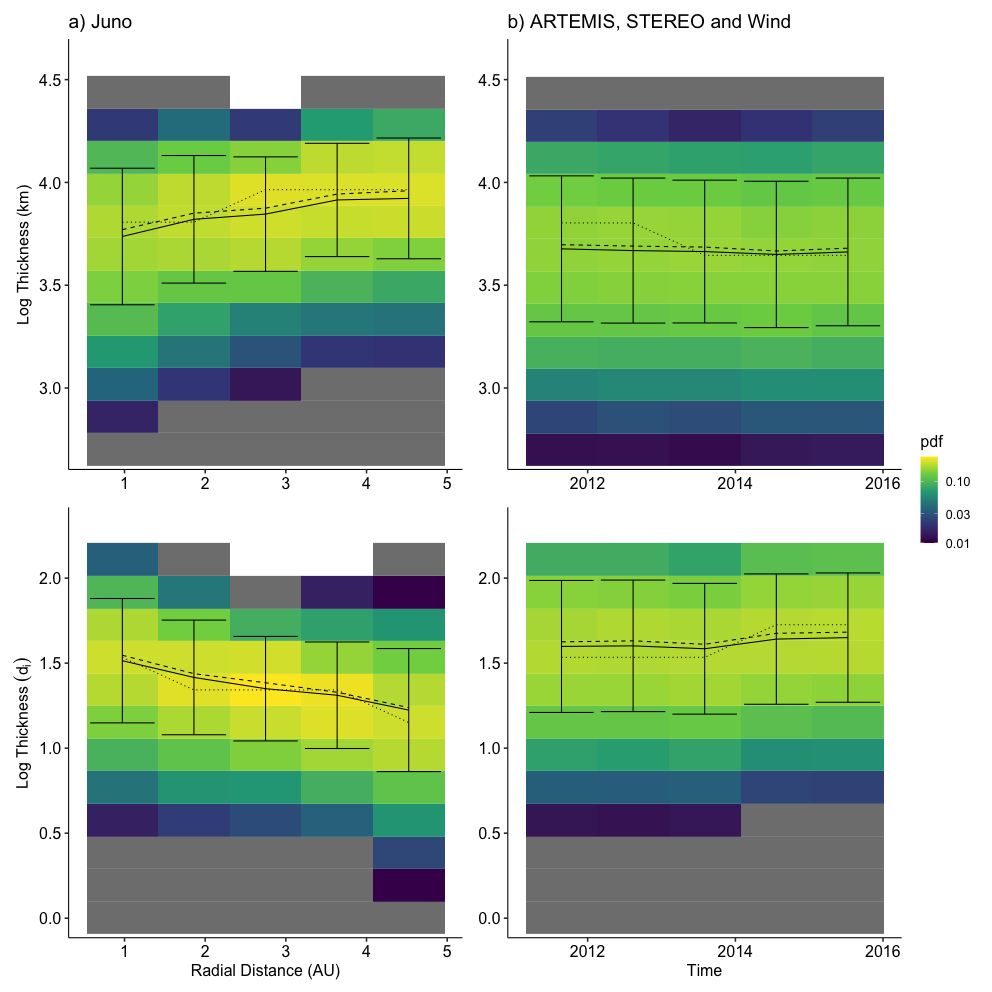

In [138]:
%%R -w 350 -h 350 -u mm

p <- plot_thickness_comparison(jno_df, other_events, p1title="a) Juno")
save_plot("new/thickness/thickness_k_dist")
p

In [82]:
%%R -w 350 -h 350 -u mm

p1 <- plot_q_and_qnorm_r_l(
    jno_df_8hz_tau_20_der,
    y_lim1=c(100, 6000), 
    y_lim2=c(0.1,20)
)

p2 <- plot_q_and_qnorm_r_j0(
    jno_df_8hz_tau_20_der,
    y_lim1 = c(0.1, 50),
    y_lim2 = c(0.02, 10)
)

(p1 |  p2) + plot_annotation(
  title = 'Juno: 8Hz, Tau 20s, Derivative Method',
  theme = theme(plot.title = element_text(size = 18))
)

In [81]:
%%R -w 350 -h 350 -u mm

p <- plot_thickness_comparison(jno_df_8hz_tau_20, other_events, p1title="a) Juno: High Time Resolution, Low Tau")
save_plot("new/thickness/thickness_k_dist-8hz-tau_20")

p <- plot_thickness_comparison(jno_df_8hz, other_events, p1title="a) Juno: High Time Resolution")
save_plot("new/thickness/thickness_k_dist-8hz")

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Saving 13.8 x 13.8 in image
Saving 13.8 x 13.8 in image
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Saving 13.8 x 13.8 in image
Saving 13.8 x 13.8 in image

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image

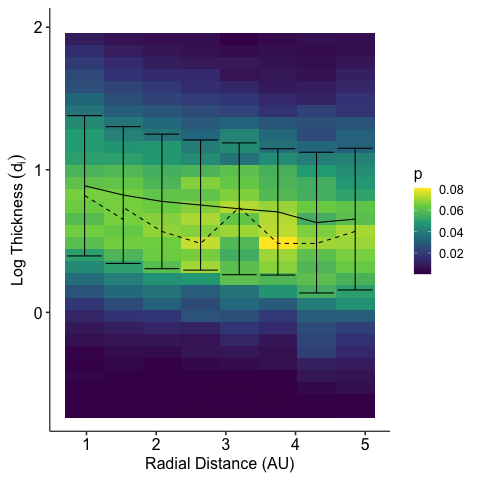

In [40]:
%%R
x_col <- "radial_distance"
xlab <- "Radial Distance (AU)"

y_col <- "L_k_fit"
ylab <- "Log Thickness (km)"
y_lim <- c(100, 40000)
# y_lim <- NULL
p <- plot_binned_data(jno_df, x_col = x_col, y_col = y_col, x_bins = 8, y_bins = 32, y_lim = y_lim, log_y = TRUE)
p <- p + labs(x = xlab, y= ylab)
# save_plot("new/thickness/thickness_k_fit_r_dist")

y_col <- "L_k_fit_norm"
y_lim <- c(0.2, 100)
# y_lim <- NULL
ylab <- expression(Log~Thickness~(d[i]))
p <- plot_binned_data(jno_df, x_col = x_col, y_col = y_col, x_bins = 8, y_bins = 32, y_lim = y_lim, log_y = TRUE)
p <- p + labs(x = xlab, y= ylab)
save_plot("new/thickness/thickness_k_fit_N1_r_dist")
p